# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [6]:
# import necessary packages
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Implementing the agent
B_SIZE = 64             # size of the mini batch
BUFFERSIZE = int(1e5)   # buffer size
UPDATE = 4              # update the network every 4
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.qnet_local = QNet(state_size, action_size, seed).to(device)
        self.qnet_target = QNet(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnet_local.parameters(), lr=LR)
        self.memory = ReplayBuffer(action_size, BUFFERSIZE, B_SIZE, seed)
        # UPDATE 
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        # Update and Learn
        self.t_step = (self.t_step + 1) % UPDATE
        if self.t_step == 0:
            # get learn and subsets
            if len(self.memory) > B_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnet_local.eval()
        with torch.no_grad():
            action_values = self.qnet_local(state)
        self.qnet_local.train()
        # Epsilon
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
       
        states, actions, rewards, next_states, dones = experiences

        # Q values (max)
        Q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # expected Q values
        Q_expected = self.qnet_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update
        self.soft_update(self.qnet_local, self.qnet_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:

    def __init__(self, action_size, buffersize, b_size, seed):
    
        self.action_size = action_size
        self.memory = deque(maxlen=buffersize)  
        self.b_size = b_size
        self.experience = namedtuple("Exp", field_names=[ "state","action","reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):   
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
       
        experiences = random.sample(self.memory, k=self.b_size)

        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)   
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        # Return current size
        return len(self.memory)

In [8]:
# implement a neural network
class QNet(nn.Module):
    def __init__(self, state_size, action_size, seed, f1_units=64, f2_units=64):
        super(QNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.f1 = nn.Linear(state_size, f1_units)
        self.f2 = nn.Linear(f1_units, f2_units)
        self.f3 = nn.Linear(f2_units, action_size)

    def forward(self, state):
        # for map state
        a = F.relu(self.f1(state))
        a = F.relu(self.f2(a))
        return self.f3(a)
    
# Specify state size and action size
agent = Agent(state_size=37, action_size=4, seed=0)

Episode is 100	The Avg Scoreis : 0.34
Episode is 200	The Avg Scoreis : 0.82
Episode is 300	The Avg Scoreis : 1.95
Episode is 400	The Avg Scoreis : 2.44
Episode is 500	The Avg Scoreis : 3.36
Episode is 600	The Avg Scoreis : 4.31
Episode is 700	The Avg Scoreis : 5.42
Episode is 800	The Avg Scoreis : 5.70
Episode is 900	The Avg Scoreis : 6.07
Episode is 1000	The Avg Scoreis : 7.65
Episode is 1100	The Avg Scoreis : 8.12
Episode is 1200	The Avg Scoreis : 8.92
Episode is 1300	The Avg Scoreis : 9.46
Episode is 1400	The Avg Scoreis : 9.54
Episode is 1500	The Avg Scoreis : 10.35
Episode is 1600	The Avg Scoreis : 10.45
Episode is 1700	The Avg Scoreis : 11.77
Episode is 1800	The Avg Scoreis : 12.45
Episode is 1900	The Avg Scoreis : 12.55
Episode is 2000	The Avg Scoreis : 12.58
Episode is 2100	The Avg Scoreis : 12.56
Episode is 2200	The Avg Scoreis : 11.99
Episode is 2300	The Avg Scoreis : 12.31
Episode is 2400	The Avg Scoreis : 12.83
Episode is 2500	The Avg Scoreis : 13.50


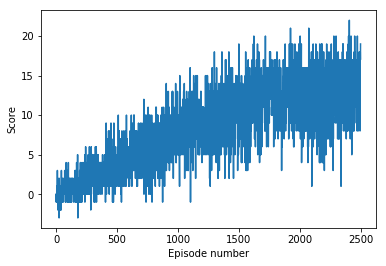

In [10]:
# Define dqn
def dqn(n_episodes=2500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999):
    # Deep Q-Learning
    ### Training mode
    
    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the env
        state = env_info.vector_observations[0]  
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   #  reward
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)      
        scores.append(score)             
        eps = max(eps_end, eps_decay*eps) 
        print('\rEpisode is {}\tThe Avg Score is: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode is {}\tThe Avg Scoreis : {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=16.0:
            print('\nEnvironment is solved at {:d} episodes!\tThe Average Score is: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnet_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode number')
plt.show()

In [11]:
# rewards plotting and loading the weights
agent.qnet_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    env_info = env.reset()[brain_name] 
    state = env_info.vector_observations[0] 
    for j in range(200):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]   
        reward = env_info.rewards[0]                  
        done = env_info.local_done[0] 
        if done:
            break

In [12]:
env.close()